# Predicting the Popularity of Venues in Downtown Toronto

__TODO__: Add description of the project (it can be the same description as the one in the assignment)

## Import the necessary libraries

In [267]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import scipy as sp

from scipy.spatial import distance  # distance matrix computations
from scipy.cluster import hierarchy  # hierarchical clustering

from sklearn.preprocessing import MinMaxScaler  # used to normalize data

import networkx as nx  # plot graphs

import requests  # handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pylab  # plotting dendograms
import seaborn as sns  # plotting in general
import branca  # add legend to folium map

import folium  # map rendering library

import geopandas  # DataFrame to GeoJSON

import warnings

## Get the data from the Toronto Open Data API

In [2]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
payload = {"id": "ae4e10a2-9eaf-4da4-83fb-f3731a30c124"}
response = requests.get(url, params=payload).json()
traffic_df = pd.read_excel(response["result"]['resources'][0]['url'])
traffic_df.head()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368


Drop and rename some of the columns to make the table easier to work with.

In [3]:
col_rename = {'Side 1 Route': 'Side1',
              '8 Peak Hr Vehicle Volume': 'VehicleVolume',
              '8 Peak Hr Pedestrian Volume': 'PedestrianVolume'}
traffic_df.drop(['TCS #', 'Midblock Route', 'Side 2 Route', 'Activation Date', 'Count Date'], axis=1, inplace=True)
traffic_df.rename(columns=col_rename, inplace=True)

# add column with the intersection name
intersections = traffic_df.loc[:, 'Main'] + ' & ' + traffic_df.loc[:, 'Side1']
traffic_df.loc[:, 'Intersection'] = intersections

traffic_df.head()

,Main,Side1,Latitude,Longitude,VehicleVolume,PedestrianVolume,Intersection
0,JARVIS ST,FRONT ST E,43.649418,-79.371446,15662,13535,JARVIS ST & FRONT ST E
1,KING ST E,JARVIS ST,43.650461,-79.371924,12960,7333,KING ST E & JARVIS ST
2,JARVIS ST,ADELAIDE ST E,43.651534,-79.372360,17770,7083,JARVIS ST & ADELAIDE ST E
3,JARVIS ST,RICHMOND ST E,43.652718,-79.372824,19678,4369,JARVIS ST & RICHMOND ST E
4,JARVIS ST,QUEEN ST E,43.653704,-79.373238,14487,3368,JARVIS ST & QUEEN ST E


Let's look at the minimum and maximum values of each numeric column to see if we need to clean up further.

In [117]:
def MinMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

traffic_df._get_numeric_data().apply(MinMax)

,Latitude,Longitude,VehicleVolume,PedestrianVolume,Count
min,43.591686,-79.63929,1081,0,1
max,43.855450,-79.13159,56432,47561,69


We see that there is at least one intersection where the pedestrian volume is zero. We don't want to consider intersections where there is none to very little pedestrian traffic. Let's now look at the distribution of pedestrian volume in the city.

In [144]:
traffic_df.drop(traffic_df[traffic_df['PedestrianVolume'] == 0].index, inplace=True)

(222,)


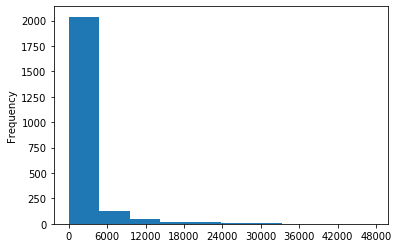

In [357]:
num_bins = round(traffic_df.shape[0]/10)
data = traffic_df['PedestrianVolume']
print(traffic_df.loc[traffic_df['PedestrianVolume'] > 5000]['PedestrianVolume'].shape)

fig, ax = plt.subplots()
data.plot.hist(bins=num_bins)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

The plot below shows a scatter plot of the latitudes and longitudes in the data. This should have roughly the shape of the city, but we see that there is an outlier to the right of -74 degrees of longitude. We are not interested in an intersection that is far away from the core of the city. as such, remove any intersections that have a degree of longitude greater than 74 degrees of longitude, and re-plot to see the corrected data.

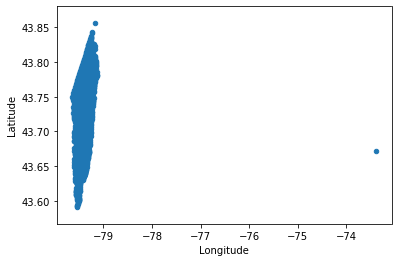

In [5]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

In [6]:
traffic_df.drop(traffic_df[traffic_df['Longitude'] > -74].index, inplace=True)

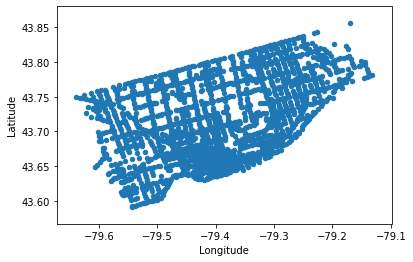

In [7]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

We see that the plot now resembles the shape of the city.

We want to visualize the busiest intersections in order to choose a region with the highest pedestrian traffic where we will explore venues and hopefully come up with interesting predictions. The following plot shows the intersections in the city, where intersections with a darker colour are busier than those with a lighter colour.

# TODO
- Add legend to log plot
- Try equal-depth binning and map. If this doesn't work, just go with the log map. Remeber that the maps aren't really that important! You have other shit to do bratha.

In [176]:
def NormalizeColors(data):
    # Function to normalize data values to be used in a matplotlib colormap, and return the function
    # that normalizes the data.
    #
    # Args:
    #   data: an object containing numeric data, as well as having the attributes 'min' and 'max'.
    #
    # Returns:
    #   norm: a matplotlib.colors.Normalize object
    
    data_min, data_max = data.min(), data.max()
    
    norm = colors.Normalize(vmin=data_min, vmax=data_max)
    
    return norm

In [189]:
def ColorsArray(data, norm, cmap):
    # Function to calculate hexadecimal values in the range of the given colormap.
    #
    # Args:
    #   data: an array of numerical data
    #   norm: a pandas Series containing numerical data.
    #   cmap: a matplotlib.colors.Colormap object which represents a matplotlib colormap.
    #
    # Returns:
    #   hex_colors: a list of hexadecimal values
    
    norm_data = norm(data.tolist())  # object consumes list
    colors_array = cmap(norm_data)
    hex_colors = [colors.rgb2hex(i) for i in colors_array]
    
    return hex_colors

In [334]:
def GetZoomBounds(latitudes, longitudes, offset=0):
    # Function to get the coordinates for the bounding box that defines the level of zoom in a
    # folium map.
    #
    # Args:
    #   latitudes: array of latitude values.
    #   longitudes: array of longitude values.
    #   offset: proportion of the maximum latitude and longitude used to offset the bounding box
    #           corners. Positive number to contract the box, negative number to dilate the box.
    #
    # Returns:
    #   (sw, ne): tuple of lists that contain the south-west and north-east corners of the bounding
    #             box, respectively.
    
    min_lat, max_lat = latitudes.min(), latitudes.max()
    min_lng, max_lng = longitudes.min(), longitudes.max()
    max_lat_pct = max_lat * offset
    max_lng_pct = max_lng * -offset
    sw = [min_lat + max_lat_pct, min_lng + max_lng_pct]
    ne = [max_lat - max_lat_pct, max_lng - max_lng_pct]
    
    return sw, ne

def CreateVolumeMap(centre_lat, centre_lng, latitudes, longitudes, colors, is_fit_bounds=False, 
                    offset=0, legend_dict = {}):
    # Function to create points on a map representing geographical locations. The points are coloured
    # based on the parameter colors.
    #
    # Args:
    #   centre_lat: latitude value of the centre of the map
    #   centre_lng: longitude value of the centre of the map
    #   latitudes: array or Series of latitude values
    #   longitudes: array or Series of longitude values
    #   colors: array of hexadecimal values representing colors for a matplotlib colormap
    #   is_fit_bounds: if True, will modify the bounding box of the map.
    #   offset: see function GetZoomBounds
    #   legend_dict: dictionary containing information to plot the legend. If empty, no legend is
    #               plotted.
    #
    # Returns:
    #   m: folium.Map object
        
    m = folium.Map(location=[centre_lat, centre_lng], tiles = 'cartodbpositron', zoom_start=11, control_scale=True)

    for lat, lng, color in zip(latitudes,
                               longitudes,
                               colors):
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=1).add_to(m)

    if is_fit_bounds:
        # fix a bounding box for a better zoom level
        sw, ne = GetZoomBounds(latitudes, longitudes, offset)
        m.fit_bounds([sw, ne])
    
    if len(legend_dict) > 0:
        leg = branca.colormap.StepColormap(colors=legend_dict['colors'],
                                              index=legend_dict['index'],
                                              vmin=legend_dict['vmin'],
                                              vmax=legend_dict['vmax'],
                                              caption=legend_dict['caption'])
    
        leg.add_to(m)

    return m

In [356]:
# normalize data for colormap
log_volume = np.log(traffic_df['PedestrianVolume'])
norm = NormalizeColors(log_volume)

cmap = cm.YlGn

# get the array of hexadecimal colors to be used in the map
volume_colors = ColorsArray(log_volume, norm, cmap)

m = CreateVolumeMap(43.6532, -79.3832, traffic_df['Latitude'], traffic_df['Longitude'],
                    volume_colors, True, 0.001)

m

[    0.  1999.  6820. 14362. 22376. 28880. 33410. 41088. 47561.]


(array([2.117e+03, 9.700e+01, 0.000e+00, 3.200e+01, 1.200e+01, 0.000e+00,
        7.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([    0. ,  4756.1,  9512.2, 14268.3, 19024.4, 23780.5, 28536.6,
        33292.7, 38048.8, 42804.9, 47561. ]),
 <a list of 10 Patch objects>)

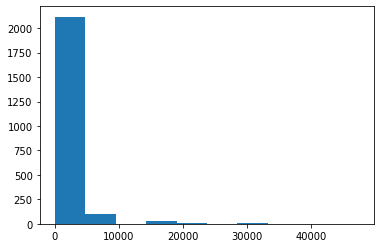

In [361]:
volume = traffic_df['PedestrianVolume'].values
temp_volume = volume
volume_mean = 0
bins = [0]

# head/tail method to get the bins to be used for coloring the poitns on the map
while len(temp_volume) > 1:
    temp_volume = temp_volume[temp_volume > volume_mean]
    volume_mean = temp_volume.mean()
    bins.append(volume_mean)

# reverse the order so that the bin with value 0 is included
bins = np.round(np.array(bins))[::-1]

# map each pedestrian volume value to its corresponding bin
volume_in_bins = np.take(bins, np.digitize(volume, bins, right=False))

# reverse to get original order
bins = bins[::-1]
volume_in_bins[0:5]
print(bins)
plt.hist(volume_in_bins)

In [354]:
norm_volume = NormalizeColors(volume_in_bins)
norm_bins = NormalizeColors(bins)
cmap = cm.YlGn

volume_colors = ColorsArray(volume_in_bins, norm_volume, cmap)
bins_colors = ColorsArray(bins, norm_bins, cmap)

legend_dict = {'colors': bins_colors,
              'index': bins,
              'vmin': 0,
              'vmax': volume.max(),
              'caption': 'Pedestrian Traffic Volume in Toronto Intersections'}

m = CreateVolumeMap(43.6532, -79.3832, traffic_df['Latitude'], traffic_df['Longitude'],
                    volume_colors, True, 0.001, legend_dict)

m

In [ ]:
fig = plt.figure()

# scatter plot of the data
plt.scatter(x=traffic_df['Longitude'].tolist(), y=traffic_df['Latitude'].tolist(), c=traffic_df['PedestrianVolume'].tolist())
plt.xticks(np.round(np.arange(min(traffic_df['Longitude']), max(traffic_df['Longitude']), 0.05), 2))
plt.yticks(np.round(np.arange(min(traffic_df['Latitude']), max(traffic_df['Latitude']), 0.05), 2))

# map
mplleaflet.display()

#plt.show()

In the plot above, we can see that the busiest intersections in terms of pedestrian volume are in the region centred around -79.39 longitude and 43.64 latitude. This makes sense since that is the core of the city. We will be using this region to explore its venues and predict the popularity of new venues.

In the map below you can see the bounding box for the region that we will be looking at. That is, we will only use intersections and venues that are located in this region.

In [ ]:
lat = 43.6525
lng = -79.381667
m = 5000  # metres
a = 6378137  # Radius of earth at equator (m)
e2 = 0.00669437999014  # eccentricity squared
r = np.pi / 180  # convert to radians

# distance of 1 degree latitude
d1 = r * a * (1 - e2) / (1 - e2 * np.sin(lat * r) ** 2) ** (3 / 2)

# distance of 1 degree longitude
d2 = r * a * np.cos(lat * r) / np.sqrt(1 - e2 * np.sin(lat * r) ** 2)

# Bounding box coordinates
min_lat, max_lat = lat - m / d1, lat + m / d1
min_lng, max_lng = lng - m / d2, lng + m / d2

print(min_lat, min_lng, max_lat, max_lng)

In [ ]:
print(traffic_df.shape)
lat_bool = traffic_df.Latitude.between(min_lat, max_lat)
lng_bool = traffic_df.Longitude.between(min_lng, max_lng)

traffic_df = traffic_df[lat_bool & lng_bool]
print(traffic_df.shape)

In [ ]:
def CreateMap(lat, lng, zoom_start=12, with_colour=False, n_clusters=0):
    # if with_colour = True, you must specify the number of clusters
    
    # create map
    m = folium.Map(location=[43.65, -79.38], zoom_start=zoom_start)

    if with_colour:
        # set color scheme for the clusters
        x = np.arange(n_clusters)
        ys = [i + x + (i*x)**2 for i in range(n_clusters)]
        colors_array = cm.YlOrRd(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    if with_colour:
        for lat, lng, main_st, side_st, cluster in zip(traffic_df['Latitude'],
                                                       traffic_df['Longitude'],
                                                       traffic_df['Main'], 
                                                       traffic_df['Side1'],
                                                       traffic_df['ClusterLabel']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_opacity=0.7).add_to(m)
    else:
        for lat, lng, main_st, side_st in zip(traffic_df['Latitude'],
                                              traffic_df['Longitude'],
                                              traffic_df['Main'], 
                                              traffic_df['Side1']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                fill=True,
                fill_opacity=0.7).add_to(m)

    return m

In [ ]:
CreateMap(43.65, -79.38)

In [ ]:
features = ['Latitude', 'Longitude']
feature_set = traffic_df[features]

In order to determine if the features need to be normalized, let's look at the range of each feature.

In [ ]:
traffic_df[features].max() - traffic_df[features].min()

We see that the ranges differ significantly, so we will normalize our data to get a more accurate clustering.

In [ ]:
x = feature_set.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

Now we calculate the distance matrix of the feature matrix. We use the _cityblock_ metric to calculate the city block distance between the points.

In [ ]:
# calculate the distance between points
dist_array = distance.pdist(feature_mtx, metric='cityblock')

# calculate the distance matrix to be used in hierarchical clustering
dist_matrix = distance.squareform(dist_array)
dist_matrix

Now we want to use the distance matrix to create a hierarchical clustering of the intersections using their proximity to each other. The goal is to cluster intersections that are close to each other in order to later retrieve the venues that are inside each cluster.

In [ ]:
# ignore warning when performing the hierarchical clustering
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Z = hierarchy.linkage(dist_matrix, method='average')

In [ ]:
max_clusters = 10
clusters = hierarchy.fcluster(Z, max_clusters, criterion='maxclust')

traffic_df['ClusterLabel'] = clusters

In [ ]:
CreateMap(43.65, -79.38, with_colour=True, n_clusters=max_clusters, zoom_start = 13)

In [ ]:
traffic_df.loc[traffic_df['Main'] == 'STEELES AVE E'].loc[traffic_df['Side1'] == 'PICKERING TOWN LINE']

In [ ]:
traffic_df.drop(index=51, inplace=True)

In [ ]:
fig, ax = plt.subplots()
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude', c='PedestrianVolume', colormap='YlOrRd', ax=ax, figsize=(15,10))

In [ ]:
traffic_df.head()